### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/CI2020-hackathon/James/'

Mounted at /gdrive
/gdrive/My Drive/CI2020-hackathon/James


In [ ]:
device='gpu' # 'tpu'/'gpu'

In [ ]:
if device=='gpu':
  gpu_info = !nvidia-smi
  print('\n'.join(gpu_info))
  device='cuda'

Sat Oct  3 18:27:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data

In [ ]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import pandas as pd
import torch
import time
import pandas as pd
import os

In [ ]:
CloudTop = np.load("../public_data/X_train_CI20.npy")
TrueColor = np.load("../public_data/Y_train_CI20.npy")
Dates = np.load("../public_data/dates_train_CI20.npy")
TrueColor.shape, CloudTop.shape

In [ ]:
Dates = pd.to_datetime(Dates)

## Exploratory Data Analysis

### Preprocessing

In [ ]:
mask = np.where(np.sum(TrueColor,axis=(1,2,3))>0.)
TrueColorNZ = TrueColor[mask]
CloudTopNZ = CloudTop[mask]
Dates = Dates[mask]

In [ ]:
darkness_intensity = 5

# fraction of pixels which are dark per image
val = (TrueColorNZ.sum(axis=3)<darkness_intensity).mean(axis=(1,2))

Removed 977 entries out of 4517
Below are the most dark images kept with cutoff fraction 0.002. Dark regions shown with contour.


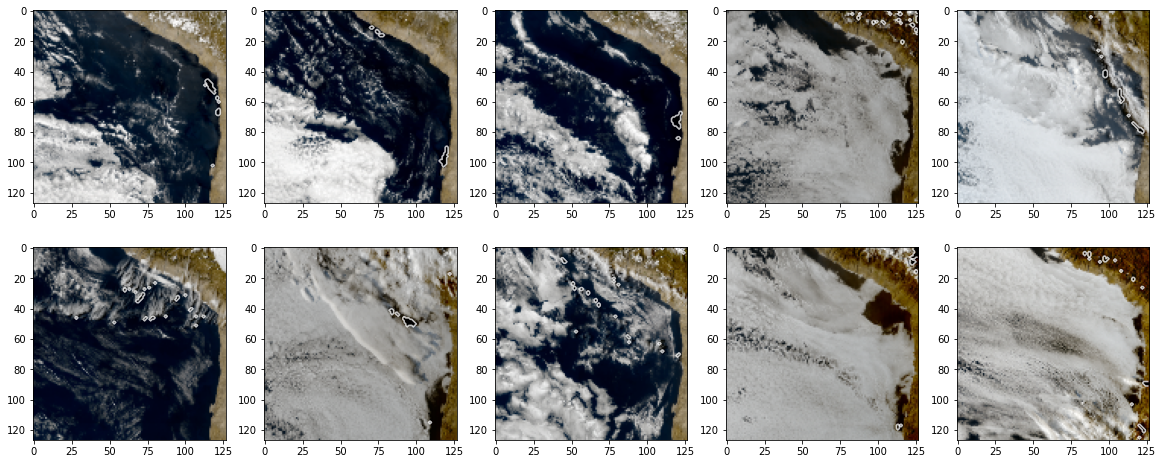

Below are the least dark images discarded with cutoff fraction 0.002. Dark regions shown with contour.


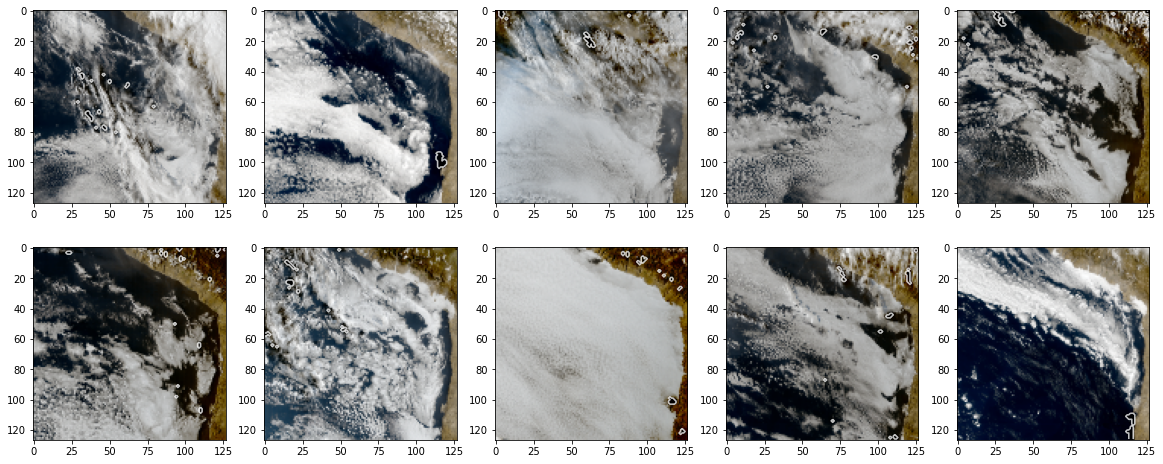

In [ ]:
# keep images with at most this fraction dark
cutoff = 0.002
keep = val<cutoff
print(f"Removed {sum(~keep)} entries out of {len(TrueColorNZ)}")

# Find darkest images kept
indexes = np.arange(len(TrueColorNZ))
keep_indexes = np.array([y[1] for y in sorted(enumerate(indexes[keep]), key=lambda x: val[keep][x[0]], reverse=True)])
discard_indexes = np.array([y[1] for y in sorted(enumerate(indexes[~keep]), key=lambda x: val[~keep][x[0]], reverse=False)])

N=10
max_per_row = 5

print(f'Below are the most dark images kept with cutoff fraction {cutoff}. Dark regions shown with contour.')

plt.figure(figsize=(20,8))
for i, index in enumerate(keep_indexes[:N]):
  plt.subplot((N-1)//max_per_row+1, max_per_row, i+1)
  plt.imshow(array_to_img(TrueColorNZ[index,:,:,:]))
  plt.contour(array_to_img(TrueColorNZ[index,:,:,:].sum(axis=2, keepdims=True)<darkness_intensity), levels=[0,1], colors='white', alpha=0.5)
plt.show()

print(f'Below are the least dark images discarded with cutoff fraction {cutoff}. Dark regions shown with contour.')
plt.figure(figsize=(20,8))
for i, index in enumerate(discard_indexes[:N]):
  plt.subplot((N-1)//max_per_row+1, max_per_row, i+1)
  plt.imshow(array_to_img(TrueColorNZ[index,:,:,:]))
  plt.contour(array_to_img(TrueColorNZ[index,:,:,:].sum(axis=2, keepdims=True)<darkness_intensity), levels=[0,1], colors='white', alpha=0.5)
plt.show()


In [ ]:
TrueColorFiltered = TrueColorNZ[keep]
CloudTopFiltered  = CloudTopNZ[keep]
DatesFiltered = Dates[keep]

# Set dark pixels to NaN so we don't learn these
TrueColorFiltered[TrueColorFiltered.sum(axis=3)<darkness_intensity] = np.nan

(array([373., 342., 349., 339., 329., 345., 350., 345., 325., 443.]),
 array([11. , 12.1, 13.2, 14.3, 15.4, 16.5, 17.6, 18.7, 19.8, 20.9, 22. ]),
 <a list of 10 Patch objects>)

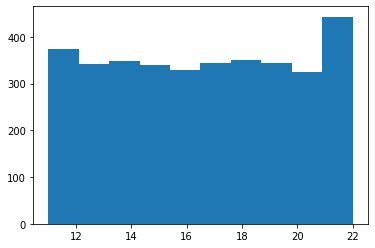

In [ ]:
plt.hist(DatesFiltered.hour.values)

In [ ]:
np.isnan(TrueColorFiltered).mean()

7.657190455623849e-05

In [ ]:
TrueColorFiltered.shape, CloudTopFiltered.shape

((3540, 127, 127, 3), (3540, 127, 127, 3))

In [ ]:
del CloudTop, TrueColor

In [ ]:
from lib.unet_plus import NestedUNet
from lib.ssim import SSIM

calc_ssim = SSIM(filter_nan=True, channel=3)
loss_fn = lambda x1, x2: -calc_ssim(x1,x2)

In [ ]:
TimeFields = np.zeros(CloudTopFiltered.shape[:1]+(1,))
# Fraction of day field
TimeFields[:,0] = ((DatesFiltered.hour.values + DatesFiltered.minute.values/60)/24)

In [ ]:
model = NestedUNet(num_classes=3, input_channels=3, input_1d_features=1, nb_filter=[8, 16, 32, 64, 128],).to(device)
optim = torch.optim.Adam(model.parameters())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

def pad(data):
  return F.pad(input=data, pad=(0, 1, 0, 1), mode='constant', value=0)

In [ ]:
batch_size = 10
test_size=500

tensor_x = pad(torch.from_numpy(CloudTopFiltered.transpose((0,3,1,2))/255))
tensor_t = torch.from_numpy(TimeFields.astype(np.float32))
tensor_y = torch.from_numpy(TrueColorFiltered.transpose((0,3,1,2))/255.)

dataset = TensorDataset(tensor_x, tensor_t, tensor_y)

# split into train and test sets and create dataloader
train_set, test_set = torch.utils.data.random_split(dataset, (len(dataset)-test_size, test_size), generator=torch.Generator().manual_seed(42))
dataloader = DataLoader(train_set, batch_size=batch_size)

test_X, test_t, test_y = test_set[:]
test_X = test_X.to(device)
test_t = test_t.to(device)
test_y = test_y.to(device)

del tensor_x, tensor_y, tensor_t, train_set, test_set, dataset, CloudTopNZ, TrueColorNZ

In [ ]:
STATS_PERIOD = 50
MODEL_DUMP_ROOT="output_dump"

N=50

class net_container:
    def __init__(self, net, optimizer, loss_func, test_X, test_t, test_y, run_name=None):
        self.net = net
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.run_name = run_name
        self.test_X = test_X
        self.test_t = test_t
        self.test_y = test_y
        
        self.running_train_loss = 0
        self.train_losses = []
        self.test_losses = []
        self.batch = []
        self.time_elapsed = []
        
    
    def train_step(self, X, t, y, batch_number):

        # forward + backward + optimize
        self.net.train()
        
        outputs = self.net([X, t])[:,:,:-1, :-1]
        train_loss = self.loss_func(outputs, y)

        self.running_train_loss += train_loss.item()
        
        train_loss.backward()
        self.optimizer.step()

        # zero the parameter gradients
        self.optimizer.zero_grad()

        del outputs, train_loss

        # print statistics
        if batch_number == 0 or batch_number % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches

            # Train loss
            if batch_number == 0:
                mean_train_loss = self.running_train_loss
                self.t0 = time.time()
            else:
                mean_train_loss = self.running_train_loss / STATS_PERIOD

            self.train_losses.append(mean_train_loss)
            
            self.running_train_loss = 0.

            # Test loss
            self.net.eval()
            
            test_loss=0
            for i in range((self.test_X.shape[0]-1)//N + 1):
              test_outputs = self.net([
                  self.test_X[i*N:(i+1)*N],
                  self.test_t[i*N:(i+1)*N]
              ])[:,:,:-1, :-1]
              l = self.loss_func(test_outputs, self.test_y[i*N:(i+1)*N]).item()
              l = l * min(N, self.test_X.shape[0]-i*N)/self.test_X.shape[0]
              test_loss += l

            self.test_losses.append(test_loss)
           
            self.batch.append(batch_number)
            self.time_elapsed.append(time.time() - self.t0)

            print(f"batch {batch_number} | {self.time_elapsed[-1]}s elapsed | train_loss {mean_train_loss:.5f} | test_loss {self.test_losses[-1]:.5f}"+" "*10, flush=True)
            
            if self.run_name:
                thisdir = os.path.join(MODEL_DUMP_ROOT, self.run_name)
                if batch_number==0:
                    
                    os.system(f"rm -rf {thisdir}")
                    os.makedirs(thisdir)
                    
                              
                df = pd.DataFrame({
                    'time_elapsed':self.time_elapsed,
                    'batch':self.batch,
                    'train_loss':self.train_losses,
                    'test_loss':self.test_losses,
                }).to_csv(os.path.join(thisdir, 'training_stats.csv'))
                
                if test_loss == min(self.test_losses):
                    torch.save(self.net.state_dict(), os.path.join(thisdir, 'best_model.pt'))

In [ ]:
wrapped_model = net_container(model, optim, loss_fn, test_X, test_t, test_y, run_name='unet_filt_t')

bn = 0

In [ ]:
batch_epochs=[(10, 60), (32, 30), (64, 30), (128, 20), (256, 20)]

for batch_size, epochs in batch_epochs:

  print(f"transition to (batch:{batch_size}, epochs: {epochs})")
  dataloader = DataLoader(dataloader.dataset, batch_size=batch_size)

  for _ in range(epochs):
      
      for X, t, y in dataloader:
          X = X.to(device)
          t = t.to(device)
          y = y.to(device)
          wrapped_model.train_step(X,t,y,bn)
          bn+=1

## Evaluate and reload best model

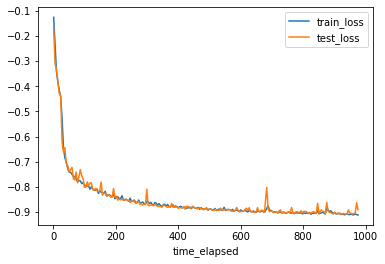

In [ ]:
df = pd.read_csv('output_dump/unet_filt_t/training_stats.csv')
df = df[df.train_loss>-1]
df.plot(x='time_elapsed', y=['train_loss', 'test_loss'])

Train and test loss are essentially the same so could use bigger network with more parameters

In [ ]:
df.test_loss.min()

-0.9093342423439028

In [ ]:
bn_state_dict = torch.load('output_dump/unet_filt_t/best_model.pt')

In [ ]:
model.load_state_dict(bn_state_dict)
model.eval();

In [ ]:
# Calculate scores for test set images
scores = []
for i in range(len(test_X)):
             scores += [loss_fn(model([test_X[i:i+1], test_t[i:i+1]])[:,:, :-1, :-1], test_y[i:i+1]).item()]

In [ ]:
# Sort indexes of test set images by score
indexes = [x[0] for x in sorted([(i,s) for i,s in enumerate(scores)], key=lambda x: x[1], reverse=True)]

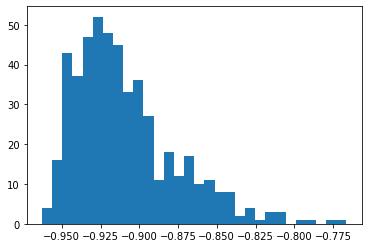

In [ ]:
# Distribution of test set scores
plt.hist(scores, bins=30)
plt.show()

In [ ]:
np.median(scores)

-0.9165669083595276

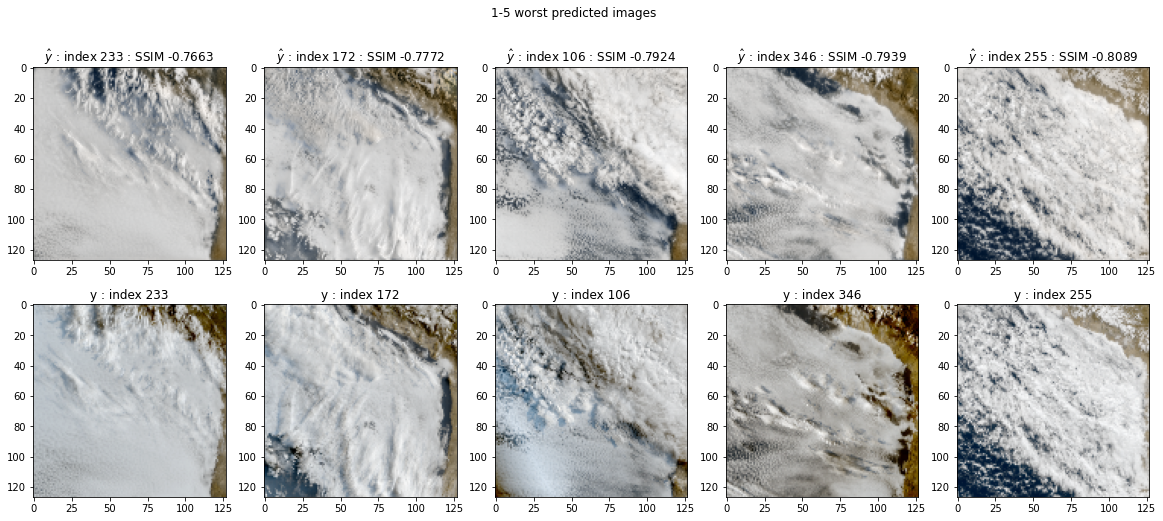

In [ ]:
# Plot preidctions and ground truth of worst scoring test set images

def post_process(imgs):
  return imgs.detach().cpu().numpy().transpose((0,2,3,1))*255

# start at this index
ind=0
# plot this many images
n=5

sample_indexes = indexes[ind:ind+n]

# Make predictions for worst scoring test set images
img_x = test_X[sample_indexes]
img_t = test_t[sample_indexes]
img_y_hat = post_process(model([img_x, img_t])[:,:, :-1, :-1])
img_y = post_process(test_y[sample_indexes])
img_y[np.isnan(img_y)]=0

plt.figure(figsize=(20,8))
plt.suptitle(f'{ind+1}-{ind+n} worst predicted images')

for i, index in enumerate(sample_indexes):
  plt.subplot(2,n,i+1)
  plt.imshow(array_to_img(img_y_hat[i]))
  plt.title('$\hat{y}$'+f' : index {index} : SSIM {scores[index]:.4f}')

  plt.subplot(2,n,i+1+n)
  plt.imshow(array_to_img(img_y[i]))
  plt.title(f'y : index {index}')

plt.show()

anecdotally, I think the shadows on these images look better, however the score on the training set and the score on the codalab platform is lower.

In [ ]:
X_test = np.load("../public_data/NightVision.npy")

# Set time to 2:15pm
t_test = (torch.ones((X_test.shape[0],1))*(14.25/24)).to(device)

X_test = pad(torch.from_numpy(X_test.transpose((0,3,1,2))/255)).to(device)

predictions = model([X_test, t_test]).detach().cpu().numpy()[:,:,:-1,:-1].transpose((0,2,3,1))*255

In [ ]:
from matplotlib import rc
import matplotlib.animation as animation

rc('animation', html='jshtml');

fig = plt.figure()
ims = []
for i in range(len(predictions)):
    im = plt.imshow(array_to_img(predictions[i,:,:,:]), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True) 

#please ignore the empty image plotted after the execution and run the next cell

In [ ]:
# filt_t
ani

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('output_dump/unet_filt_t/NightVision.mp4', writer=writer)

look at the analogs of one random test image

In [ ]:
batch_size = 10

X_test = np.load("../public_data/X_test_CI20_phase2.npy")

t_test = pd.to_datetime(np.load("../public_data/dates_test_CI20_phase2.npy"))

X_test = pad(torch.from_numpy(X_test.transpose((0,3,1,2))/255)).to(device)
t_test = torch.from_numpy(((t_test.hour.values + t_test.minute.values/60)/24).astype(np.float32)[:, np.newaxis]).to(device)

predictions = [model([X_test[i:i+batch_size], t_test[i:i+batch_size]]).detach().cpu().numpy()[:,:,:-1,:-1].transpose((0,2,3,1))*255 for i in range(0, len(X_test), batch_size)]

predictions = np.concatenate(predictions)

In [ ]:
predictions_file = "predictions"

def save_compress(predictions, name):
    np.save(f'{predictions_file}/{name}.npy', predictions)
    os.system(f"mv {predictions_file}/{name}.npy {predictions_file}/{name}.predict")
    os.system(f"zip -jrm {predictions_file}/{name}.zip {predictions_file}/{name}.predict")
    os.system(f"rm {predictions_file}/{name}.predict")

save_compress(predictions, 'Y_test_CI20_phase2_unetpp_timestamped')

In [ ]:
def load_compressed(name):
  os.system(f"unzip {predictions_file}/{name}.zip -d {predictions_file}/{name}")
  x = np.load(f'{predictions_file}/{name}/{name}.predict')
  os.system(f"rm -r {predictions_file}/{name}")
  return x